In [187]:
import pandas as pd

# files can be located in this folder
folder_path = "/Users/pedrobrito/Desktop/Pedro - Revolut/ 2. FC folder/hc_data/"

# Load all provided CSVs
transactions = pd.read_csv(folder_path + "transactions.csv")
users = pd.read_csv(folder_path + "users.csv")
currency_details = pd.read_csv(folder_path + "currency_details.csv")
fx_rates = pd.read_csv(folder_path + "fx_rates.csv")
fraudsters = pd.read_csv(folder_path + "fraudsters.csv")
countries = pd.read_csv(folder_path + "countries.csv")

print("✓ All files loaded successfully")


✓ All files loaded successfully


In [61]:
#Task A1
#Check structure of each dataset

print("transactions.csv columns:\n", transactions.columns, "\n")
print(transactions.head(3), "\n")

print("users.csv columns:\n", users.columns, "\n")
print(users.head(3), "\n")

print("currency_details.csv columns:\n", currency_details.columns, "\n")
print(currency_details.head(3), "\n")

print("fx_rates.csv columns:\n", fx_rates.columns, "\n")
print(fx_rates.head(3), "\n")

print("fraudsters.csv columns:\n", fraudsters.columns, "\n")
print(fraudsters.head(3), "\n")

print("🧾 countries.csv columns:\n", countries.columns, "\n")
print(countries.head(3), "\n")

currency_details["exponent"].value_counts()



transactions.csv columns:
 Index(['Unnamed: 0', 'CURRENCY', 'AMOUNT', 'STATE', 'CREATED_DATE',
       'MERCHANT_CATEGORY', 'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'USER_ID',
       'TYPE', 'SOURCE', 'ID'],
      dtype='object') 

   Unnamed: 0 CURRENCY  AMOUNT      STATE                CREATED_DATE  \
0           0      GBP    3738  COMPLETED  2015-10-11 09:05:43.016000   
1           1      GBP     588  COMPLETED  2015-10-11 20:08:39.150000   
2           2      GBP    1264  COMPLETED  2015-10-11 11:37:40.908000   

  MERCHANT_CATEGORY MERCHANT_COUNTRY ENTRY_METHOD  \
0               bar              AUS         misc   
1               NaN               CA         misc   
2               NaN              UKR         misc   

                                USER_ID          TYPE SOURCE  \
0  7285c1ec-31d0-4022-b311-0ad9227ef7f4  CARD_PAYMENT   GAIA   
1  20100a1d-12bc-41ed-a5e1-bc46216e9696  CARD_PAYMENT   GAIA   
2  0fe472c9-cf3e-4e43-90f3-a0cfb6a4f1f0  CARD_PAYMENT   GAIA   

           

exponent
2.0    149
0.0     22
3.0      7
8.0      4
4.0      1
6.0      1
Name: count, dtype: int64

In [188]:
# Task A1
# Build GAIA transactions summary table

# 1. Filter only GAIA transactions
gaia_tx = transactions[transactions["SOURCE"] == "GAIA"].copy()

# 2. Merge with users to get customer country
gaia_tx = gaia_tx.merge(users[["ID", "COUNTRY"]],
                        left_on="USER_ID", right_on="ID", how="left")

# 3. Merge with currency_details to get exponent for amount conversion
gaia_tx = gaia_tx.merge(currency_details[["currency", "exponent"]],
                        left_on="CURRENCY", right_on="currency", how="left")

# 4. Convert amount to readable value
gaia_tx["transaction_amount"] = gaia_tx["AMOUNT"] / (10 ** gaia_tx["exponent"])

# 5. Select final columns and rename safely
gaia_summary = gaia_tx[["USER_ID", "COUNTRY", "transaction_amount", "CURRENCY"]].rename(
    columns={"USER_ID": "customer_id", "COUNTRY": "customer_country", "CURRENCY":"currency"}
)

#confrimation that its working by just pulling 10 rows 
gaia_summary.head(10)

,customer_id,customer_country,transaction_amount,currency
0,7285c1ec-31d0-4022-b311-0ad9227ef7f4,GB,37.38,GBP
1,20100a1d-12bc-41ed-a5e1-bc46216e9696,GB,5.88,GBP
2,0fe472c9-cf3e-4e43-90f3-a0cfb6a4f1f0,GB,12.64,GBP
3,20100a1d-12bc-41ed-a5e1-bc46216e9696,GB,0.66,GBP
4,821014c5-af06-40ff-91f4-77fe7667809f,GB,9.68,GBP
5,fbe6dfd9-96de-4fde-af16-32e8a0bb7a25,GB,16.41,GBP
6,dd1f6199-127f-49ff-ba25-81393b2e66f2,GB,65.06,USD
7,dd1f6199-127f-49ff-ba25-81393b2e66f2,GB,96.93,USD
8,20100a1d-12bc-41ed-a5e1-bc46216e9696,GB,2.95,GBP
9,1a9e22bd-4cec-47c4-8196-92038ba2e603,GR,0.89,EUR


In [63]:
# Task A2
# Data Integrity Validation Checks - Check if data is reliable and free of issues
print("=== TRANSACTIONS DATA VALIDATION ===")

# 1. CREATED_DATE check
missing_dates = transactions["CREATED_DATE"].isnull().sum()
print(f"Transactions missing a date: {missing_dates}")
try:
    transactions["CREATED_DATE"] = pd.to_datetime(transactions["CREATED_DATE"])
    print("Date format: OK")
except Exception as e:
    print(f"Date format issue: {e}")

# 2. USER_ID check
missing_users = transactions["USER_ID"].isnull().sum()
print(f"Transactions missing a user ID: {missing_users}")

# 3. Duplicate transaction IDs
duplicate_ids = transactions["ID"].duplicated().sum()
print(f"Duplicate transaction IDs: {duplicate_ids}")

# 4. Amount checks
zero_value_tx = (transactions["AMOUNT"] == 0).sum()
negative_value_tx = (transactions["AMOUNT"] < 0).sum()
print(f"Transactions with zero value: {zero_value_tx}")
print(f"Transactions with negative value: {negative_value_tx}")

# 5. Currency consistency
unmatched_currencies = set(transactions["CURRENCY"].unique()) - set(currency_details["currency"].unique())
print(f"Currencies not in currency details file: {len(unmatched_currencies)}")




=== TRANSACTIONS DATA VALIDATION ===
Transactions missing a date: 0
Date format: OK
Transactions missing a user ID: 0
Duplicate transaction IDs: 0
Transactions with zero value: 12023
Transactions with negative value: 0
Currencies not in currency details file: 0


In [189]:
# Task A2
# KPI: Users whose FIRST transaction was a successful card payment over $10 USD

# Filter transactions in USD
usd_tx = transactions[transactions["CURRENCY"] == "USD"]
print(f"USD transactions: {len(usd_tx)}")

# Get exponent for USD
usd_exponent = currency_details[currency_details["currency"] == "USD"]["exponent"].values[0]

# Convert amount from cents to dollars (create a safe copy first)
usd_tx = usd_tx.copy()
usd_tx["amount_converted"] = usd_tx["AMOUNT"] / (10 ** usd_exponent)

# Sort by USER_ID and CREATED_DATE to get first transaction per user
usd_tx_sorted = usd_tx.sort_values(by=["USER_ID", "CREATED_DATE"])

# Get the first transaction for each user
first_usd_tx = usd_tx_sorted.groupby("USER_ID").first().reset_index()

# Filter: first transaction must be a completed card payment over $10
first_card_over10 = first_usd_tx[
    (first_usd_tx["STATE"] == "COMPLETED") &
    (first_usd_tx["TYPE"] == "CARD_PAYMENT") &
    (first_usd_tx["amount_converted"] > 10)
]

# Total number of users in the dataset
total_users = users["ID"].nunique()

# Final KPI
kpi_users = first_card_over10["USER_ID"].nunique()
kpi_percentage = round((kpi_users / total_users) * 100, 2)

print(f" - {kpi_users} users had their first transaction as a successful card payment over $10 USD.")
print(f" - That is {kpi_percentage}% of all users.")



USD transactions: 31542
 - 447 users had their first transaction as a successful card payment over $10 USD.
 - That is 4.34% of all users.


In [116]:
# Sanity checks

# 1. Total number of transactions in dataset
total_transactions = len(transactions)

# 2. Number of unique users who performed any transaction
unique_users_in_transactions = transactions["USER_ID"].nunique()

# 3. Number of users from users.csv
total_users_in_users_csv = users["ID"].nunique()


# 4. Number of users whose first USD transaction was a completed card payment over $10
kpi_users = first_card_over10["USER_ID"].nunique()

# Print summary
print("=== SANITY CHECK SUMMARY ===")
print(f"Total transactions: {total_transactions}")
print(f"Unique users in transactions.csv: {unique_users_in_transactions}")
print(f"Total users in users.csv: {total_users_in_users_csv}")
print(f"Users with first transaction being a completed card payment over $10 USD: {kpi_users}")


=== SANITY CHECK SUMMARY ===
Total transactions: 688651
Unique users in transactions.csv: 8021
Total users in users.csv: 10300
Users with first transaction being a completed card payment over $10 USD: 447


In [ ]:
# --

In [ ]:
# --

In [190]:
# Task B

# Tag users as known fraudsters
users["is_fraud"] = users["ID"].isin(fraudsters["user_id"])

# Make sure 'CURRENCY' is str
transactions["CURRENCY"] = transactions["CURRENCY"].astype(str)

# Merge transactions with currency exponent
tx = transactions.merge(currency_details[["currency", "exponent"]],
                        left_on="CURRENCY", right_on="currency", how="left")

# Convert amount to major units (e.g., cents to dollars)
tx["amount_major"] = tx["AMOUNT"] / (10 ** tx["exponent"])

# Get FX rates to USD only
fx_to_usd = fx_rates[fx_rates["ccy"] == "USD"]

# Merge FX rate into transactions
tx = tx.merge(fx_to_usd[["base_ccy", "rate"]],
              left_on="CURRENCY", right_on="base_ccy", how="left")

# Convert to USD (or keep same if already in USD)
tx["amount_usd"] = tx["amount_major"] * tx["rate"]
tx.loc[tx["CURRENCY"] == "USD", "amount_usd"] = tx.loc[tx["CURRENCY"] == "USD", "amount_major"]

# Merge with user details
tx_users = tx.merge(users, left_on="USER_ID", right_on="ID", how="left")

# Compute user-level transaction features (in USD)
user_stats = tx_users.groupby("USER_ID").agg(
    num_tx=("ID_x", "count"),
    total_amount=("amount_usd", "sum"),
    avg_amount=("amount_usd", "mean"),
    num_card_payments=("TYPE", lambda x: (x == "CARD_PAYMENT").sum()),
    num_p2p=("TYPE", lambda x: (x == "P2P").sum()),
    num_declined=("STATE_x", lambda x: (x == "DECLINED").sum()),
    num_completed=("STATE_x", lambda x: (x == "COMPLETED").sum()),
).reset_index()

# Add fraud label
user_stats["is_fraud"] = user_stats["USER_ID"].isin(fraudsters["user_id"])

# Split users
fraudsters_stats = user_stats[user_stats["is_fraud"] == True]
nonfraud_stats = user_stats[user_stats["is_fraud"] == False]

# Compare average metrics
features = ["num_tx", "total_amount", "avg_amount",
            "num_card_payments", "num_p2p",
            "num_declined", "num_completed"]

fraud_means = fraudsters_stats[features].mean().rename("Fraudsters Avg")
nonfraud_means = nonfraud_stats[features].mean().rename("Non-Fraudsters Avg")

# Create comparison table
comparison = pd.concat([fraud_means, nonfraud_means], axis=1)

# Add % difference
comparison["% Difference"] = 100 * ((comparison["Fraudsters Avg"] - comparison["Non-Fraudsters Avg"]) / comparison["Non-Fraudsters Avg"])

# Make row labels more readable
comparison.index = [
    "Total Transactions per User",
    "Total USD Spent per User",
    "Average USD per Transaction",
    "Card Payments per User",
    "P2P Payments per User",
    "Declined Transactions per User",
    "Completed Transactions per User"
]

# Round for clarity
comparison = comparison.round(2)

# Display
display(comparison)


,Fraudsters Avg,Non-Fraudsters Avg,% Difference
Total Transactions per User,48.64,87.30,-44.28
Total USD Spent per User,10609.92,5336.41,98.82
Average USD per Transaction,310.32,79.82,288.78
Card Payments per User,22.91,55.65,-58.84
P2P Payments per User,1.46,7.24,-79.86
Declined Transactions per User,7.31,5.63,30.00
Completed Transactions per User,35.06,74.34,-52.83


In [170]:
# Task B — Identifying top 5 suspected Fraudsters

# Step 1: Filter out known fraudsters
unknown_users = user_stats[user_stats["is_fraud"] == False].copy()

# Step 2: Apply updated fraud behavior flags (now consistent with analysis table)
unknown_users["flag_high_avg_amount"] = unknown_users["avg_amount"] > 300
unknown_users["flag_high_declined"] = unknown_users["num_declined"] > 7
unknown_users["flag_low_card_tx"] = unknown_users["num_card_payments"] < 30
unknown_users["flag_low_p2p"] = unknown_users["num_p2p"] < 3
unknown_users["flag_low_completion_ratio"] = (unknown_users["num_completed"] / unknown_users["num_tx"]) < 0.5
unknown_users["flag_low_total_tx"] = unknown_users["num_tx"] < 50

# Step 3: Compute fraud score (sum of all binary flags)
flag_cols = [col for col in unknown_users.columns if col.startswith("flag_")]
unknown_users["fraud_score"] = unknown_users[flag_cols].sum(axis=1)

# Step 4: Select top 5 users with highest fraud score
top5_flags = unknown_users.sort_values("fraud_score", ascending=False).head(5)

# Step 5: Define columns for display
cols_to_display = [
    "USER_ID", "fraud_score"
] + flag_cols + [
    "avg_amount", "num_tx", "num_declined", "num_card_payments",
    "num_p2p", "num_completed"
]

# Transpose for vertical presentation
top_users_transposed = top5_flags[cols_to_display].set_index("USER_ID").T

# Add sanity check for known fraudsters
is_known_fraudster = top_users_transposed.columns.isin(fraudsters["user_id"])
top_users_transposed.loc["Known Fraudster?"] = ["Yes" if val else "No" for val in is_known_fraudster]

# Move sanity check row to the top
new_index_order = ["Known Fraudster?"] + [i for i in top_users_transposed.index if i != "Known Fraudster?"]
top_users_transposed = top_users_transposed.loc[new_index_order]

# Make row labels readable
readable_names = {
    "fraud_score": "Fraud Risk Score",
    "flag_high_avg_amount": "High Avg Transaction Amount",
    "flag_high_declined": "Many Declined Transactions",
    "flag_low_card_tx": "Low Card Transactions",
    "flag_low_p2p": "Low P2P Transactions",
    "flag_low_completion_ratio": "Low Completion Rate",
    "flag_low_total_tx": "Low Total Transactions",
    "avg_amount": "Average USD per Transaction",
    "num_tx": "Total Transactions",
    "num_declined": "Declined Transactions",
    "num_card_payments": "Card Payments",
    "num_p2p": "P2P Payments",
    "num_completed": "Completed Transactions",
    "Known Fraudster?": "Known Fraudster?"
}

top_users_transposed = top_users_transposed.rename(index=readable_names)

# Display result
display(top_users_transposed)


USER_ID,450dc7bf-d8d2-4989-97b9-b54669255ef0,febeeef3-19a9-4e9b-8f57-4398f400f3f8,3011a01f-e9b0-477e-9791-9aa5ae6abd86,30e56a5d-ef22-4ee1-93f7-8ffbf134fb9e,df5112c5-11fe-4a59-9e12-cbbab7873b43
Known Fraudster?,No,No,No,No,No
Fraud Risk Score,6,5,5,5,5
High Avg Transaction Amount,True,False,True,False,False
Many Declined Transactions,True,True,False,True,True
Low Card Transactions,True,True,True,True,True
Low P2P Transactions,True,True,True,True,True
Low Completion Rate,True,True,True,True,True
Low Total Transactions,True,True,True,True,True
Average USD per Transaction,382.042575,10.65612,403.672359,44.289686,2.511492
Total Transactions,27,33,12,30,8


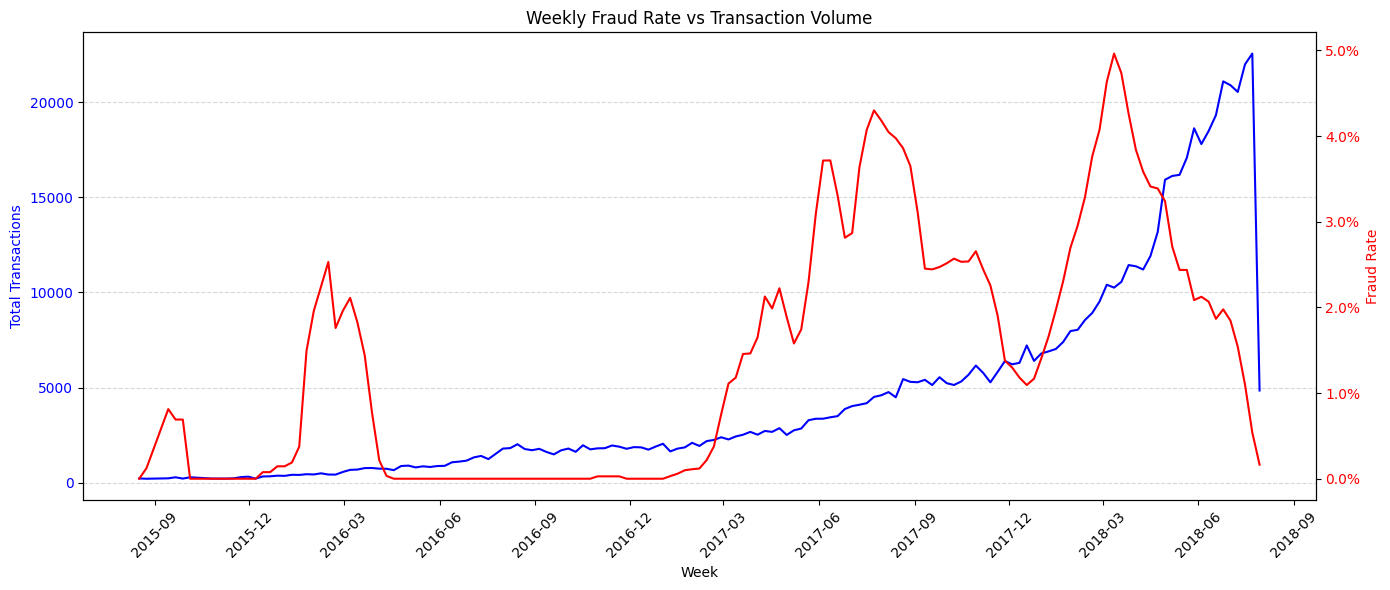

In [191]:
# Task B
# Future work & suggestions (not required but still valuable isnight to consider)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import pandas as pd

# Ensure datetime format
tx_users["CREATED_DATE_x"] = pd.to_datetime(tx_users["CREATED_DATE_x"])
tx_users["week"] = tx_users["CREATED_DATE_x"].dt.to_period("W").dt.start_time

# Mark each transaction as fraud or not
tx_users["is_fraud_tx"] = tx_users["USER_ID"].isin(fraudsters["user_id"])

# Group by week
weekly = tx_users.groupby("week").agg(
    total_tx=("ID_x", "count"),
    fraud_tx=("is_fraud_tx", "sum")
).reset_index()

# Compute fraud rate
weekly["fraud_rate"] = weekly["fraud_tx"] / weekly["total_tx"]

# Smooth fraud rate with a rolling average
weekly["fraud_rate_smooth"] = weekly["fraud_rate"].rolling(4).mean()

# Optional: remove low-volume weeks to improve clarity
weekly = weekly[weekly["total_tx"] > 200]

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left axis: total transactions
ax1.plot(weekly["week"], weekly["total_tx"], color="blue", label="Total Transactions")
ax1.set_ylabel("Total Transactions", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xlabel("Week")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
ax1.grid(True, axis="y", linestyle="--", alpha=0.5)

# Right axis: fraud rate
ax2 = ax1.twinx()
ax2.plot(weekly["week"], weekly["fraud_rate_smooth"], color="red", label="Fraud Rate (Smoothed)")
ax2.set_ylabel("Fraud Rate", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Title and layout
plt.title("Weekly Fraud Rate vs Transaction Volume")
fig.tight_layout()
plt.show()

